## Trying PySINDy with Generalized Lorenz Systems

In [2]:
# Import needed packages
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from pysindy.utils import lorenz

import pysindy as ps

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

# bad code but allows us to ignore warnings
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ODEintWarning)

/var/folders/j4/fc2yy05n3_v93dhk228gby9h0000gn/T/ipykernel_24160/338061904.py:29: DeprecationWarning: Please use `ODEintWarning` from the `scipy.integrate` namespace, the `scipy.integrate.odepack` namespace is deprecated.
  from scipy.integrate.odepack import ODEintWarning


In [40]:
# Make coefficient plot for threshold scan (Pareto)

def plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test):
    dt = t_test[1] - t_test[0]
    mse = np.zeros(len(threshold_scan))
    mse_sim = np.zeros(len(threshold_scan))
    for i in range(len(threshold_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0, :], t_test, integrator="odeint")
        if np.any(x_test_sim > 1e4):
            x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test - x_test_sim) ** 2)
    plt.figure()
    plt.semilogy(threshold_scan, mse, "bo")
    plt.semilogy(threshold_scan, mse, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.figure()
    plt.semilogy(threshold_scan, mse_sim, "bo")
    plt.semilogy(threshold_scan, mse_sim, "b")
    plt.ylabel(r"$X$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)

### Normal 3D Lorenz System

Given by: 
$$
\begin{align}
\dot{x}&=\sigma(y-x)\\
\dot{y}&=x(\rho-z)-y\\
\dot{z}&=xy-\beta z
\end{align}
$$

In this example we will use $\sigma = 10, \rho = 28, \beta = \frac{8}{3}$ and use the initial condition $(-8,8,27)$.
For this example we also collect measurements of derivatives of state variables $(\dot{x}, \dot{y}, \dot{z})$.

In [45]:
# Generate training data

dt = 0.002

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(
    lorenz, t_train_span, x0_train, t_eval=t_train, **integrator_keywords
).y.T

#Genrate testing data
t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(
    lorenz, t_test_span, x0_test, t_eval=t_test, **integrator_keywords
).y.T

In [46]:
# Fit the model

feature_names = ['x', 'y', 'z']
#poly_order = 5 #does not work (saying lambda is too big, sparsifying out all the variables)
#poly_order = 3 #assuming this is highest polynomial order consdiered in candidate functions matrix
threshold = 0.1 #lambda value in sparse regression optimization problem

#STLSQ: sequential threshold least square optimizer
#Using Polynomial Library up to polynomial order determined above
model = ps.SINDy(
    feature_names = feature_names,
    optimizer=ps.STLSQ(threshold=threshold),
    #feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(x_train, t=dt)
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = 27.992 x + -0.999 y + -1.000 x z
(z)' = -2.666 z + 1.000 x y


/Users/emilybogle/miniconda3/envs/SINDy/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.7000000000000001) and eliminated all coefficients
  warnings.warn(
/Users/emilybogle/miniconda3/envs/SINDy/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.8) and eliminated all coefficients
  warnings.warn(
/Users/emilybogle/miniconda3/envs/SINDy/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.9) and eliminated all coefficients
  warnings.warn(
/Users/emilybogle/miniconda3/envs/SINDy/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  warnings.warn(


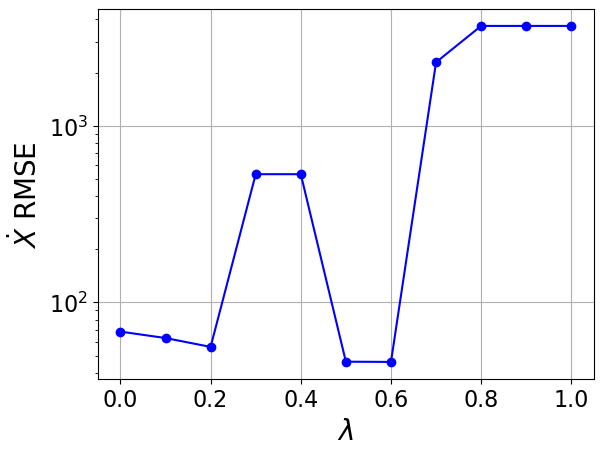

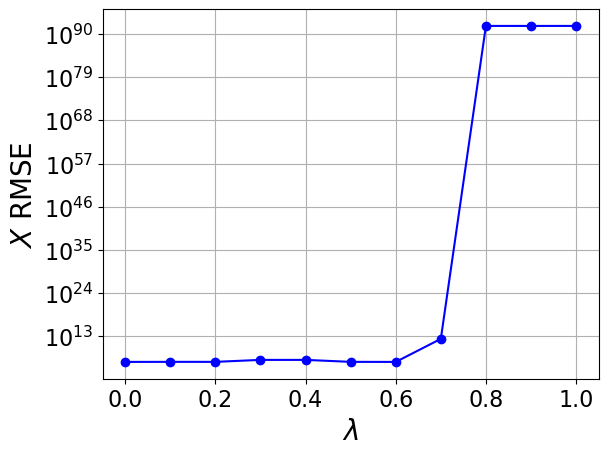

In [49]:
# Making a Pareto Curve for Lambda

threshold_scan = np.linspace(0, 1.0, 11)
model_coefs = []
#(optional) added Gaussian distributed noise with mean 0 and variance? being 10% of the root mean squared error of training data to
##    every point in the training data
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared = False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0, x_train.shape)

for i, threshold in enumerate(threshold_scan):
    opt = ps.STLSQ(threshold = threshold)
    model = ps.SINDy(feature_names = feature_names, optimizer = opt)
    model.fit(x_train_added_noise, t=dt)
    #model.fit(x_train, t=dt)
    model_coefs.append(model.coefficients())
    
plot_pareto(model_coefs, opt, model, threshold_scan, x_test, t_test)

### Normal 5D Lorenz System

Given by: 
$$
\begin{align}
\dot{x}&=\sigma(y-x)\\
\dot{y}&=x(\rho-z)-y\\
\dot{z}&=xy-\beta z - xv \\
\dot{v}&=xz -2xu-d_0v\\
\dot{u}&=2xv -4\beta u
\end{align}
$$

In this example we will use $\sigma = 10, \rho = 28, \beta = \frac{8}{3}, d_0=\frac{19}{3}$ and use the initial condition $(0,1,0,0,0)$.
For this example we also collect measurements of derivatives of state variables $(\dot{x}, \dot{y}, \dot{z}, \dot{v}, \dot{u})$.

In [50]:
# Define 5D Lorenz System
def lorenz5D(t, x, sigma=10, beta=2.66667, rho=28, d0=6.33333):
    return[
        sigma * (x[1] - x[0]),
        x[0] * (rho - x[2]) - x[1],
        x[0] * x[1] - x[0] * x[3] - beta * x[2],
        x[0] * x[2] - 2 * x[0] * x[4] - d0 * x[3],
        2 * x[0] * x[3] - 4 * beta * x[4]
    ]

# Generate training data

dt = 0.001
t_train = np.arange(0, 100, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = np.array([0, 1, 0, 0, 0])
x_train = solve_ivp(lorenz5D, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T
x_dot_train_measured = np.array(
    [lorenz(0, x_train[i]) for i in range(t_train.size)]
)

# Generate testing data
t_test = np.arange(0, 100, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([0, 1, 0, 0, 0])
x_test = solve_ivp(lorenz5D, t_test_span, 
                   x0_test, t_eval=t_test, **integrator_keywords).y.T

In [51]:
# Fit the model

feature_names = ['x', 'y', 'z', 'v', 'u']
#poly_order = 5 #does not work (saying lambda is too big, sparsifying out all the variables)
#poly_order = 3 #assuming this is highest polynomial order consdiered in candidate functions matrix
threshold = 0.1 #lambda value in sparse regression optimization problem

#STLSQ: sequential threshold least square optimizer
#Using Polynomial Library up to polynomial order determined above
model = ps.SINDy(
    feature_names = feature_names,
    optimizer=ps.STLSQ(threshold=threshold),
    #feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(x_train, t=dt)
model.print()

(x)' = -10.000 x + 10.000 y
(y)' = 27.998 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y + -1.000 x v
(v)' = -6.332 v + 1.000 x z + -2.000 x u
(u)' = -10.666 u + 2.000 x v


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.4197787057174D+01   r2 =  0.2376059414171D-10


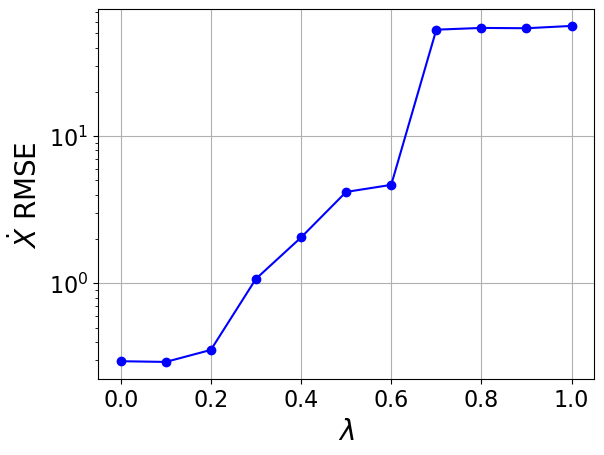

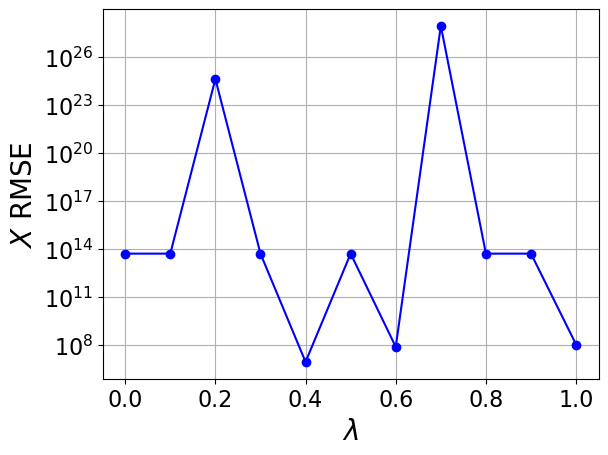

In [28]:
# Making a Pareto Curve for Lambda

threshold_scan = np.linspace(0, 1, 11)
model_coefs = []
#(optional) added Gaussian distributed noise with mean 0 and variance? being 1% of the root mean squared error of training data to
##    every point in the training data
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared = False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 100.0, x_train.shape)

for i, threshold in enumerate(threshold_scan):
    opt = ps.STLSQ(threshold = threshold)
    model = ps.SINDy(feature_names = feature_names, optimizer = opt)
    model.fit(x_train_added_noise, t=dt)
    #model.fit(x_train, t=dt)
    model_coefs.append(model.coefficients())
    
plot_pareto(model_coefs, opt, model, threshold_scan, x_test, t_test)